In [9]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

import scipy.io
import numpy as np
import h5py


def imagesc(x):
    plt.imshow(x,extent = [0,1,0,1])


In [16]:
srate = 512

In [10]:
datafile = 'experiment_data_co.h5'

In [24]:
with h5py.File(datafile,'r+') as f1:
    print(list(f1.keys()))
    print(list(f1['protocol1'].keys()))

['channels', 'fs', 'protocol0', 'protocol1', 'settings.xml', 'stream_info.xml']
['mark_data', 'par_data', 'posx_data', 'posy_data', 'raw_data', 'raw_other_data', 'reward_data', 'signals_data', 'signals_stats', 'state_data', 'timestamp_data']


In [25]:
with h5py.File(datafile,'r+') as f1:
    list(f1.keys())[0]
    
    raw_data = np.array(f1['protocol1']['raw_data'])

    posx_data_full = np.array(f1['protocol1']['posx_data'])
    posy_data_full = np.array(f1['protocol1']['posy_data'])

    state_data = np.array(f1['protocol1']['state_data'])
    par_data = np.array(f1['protocol1']['par_data'])

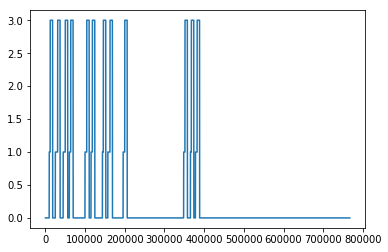

In [30]:
plt.plot(state_data[1000:srate*1500])

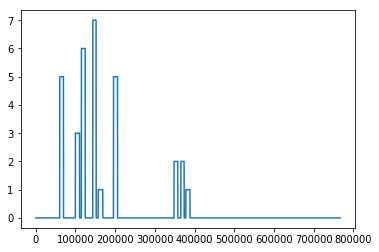

In [31]:
plt.plot(par_data[1000:srate*1500])